In [1]:
import sys
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
from functools import partial
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import LlamaTokenizer, LlamaForCausalLM
from tqdm import tqdm
from peft import PeftModel

sys.path.append("../")
from data.data_utils import *

from pp_utils import (
    compute_topk_components,
    eval_circuit_performance,
    get_mean_activations,
    get_random_circuit,
)
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 5
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

/home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Loading Evaluation Data

In [2]:
tokenizer = LlamaTokenizer.from_pretrained(
    "hf-internal-testing/llama-tokenizer", padding_side="right"
)
tokenizer.pad_token_id = tokenizer.eos_token_id

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
data_file = "../data/dataset.jsonl"
batch_size = 50

raw_data = sample_box_data(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file,
    architecture="LlamaForCausalLM",
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 500


## Loading Circuits

In [3]:
with open("./results/circuits/llama_circuit.json", "r") as f:
    llama_circuit = json.load(f)

with open("./results/circuits/goat_circuit.json", "r") as f:
    goat_circuit = json.load(f)

In [5]:
print("Llama Circuit")
print(f"Value Fetcher Heads: {len(llama_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(llama_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(llama_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(llama_circuit['struct_reader'])}")
print(
    f"Total Heads: {len(llama_circuit['value_fetcher']) + len(llama_circuit['pos_transmitter']) + len(llama_circuit['pos_detector']) + len(llama_circuit['struct_reader'])}"
)

Llama Circuit
Value Fetcher Heads: 40
Position Transmitter Heads: 7
Position Detector Heads: 20
Structure Reader Heads: 5
Total Heads: 72


In [6]:
print("GOAT CIRCUIT")
print(f"Value Fetcher Heads: {len(goat_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(goat_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(goat_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(goat_circuit['struct_reader'])}")
print(
    f"Total Heads: {len(goat_circuit['value_fetcher']) + len(goat_circuit['pos_transmitter']) + len(goat_circuit['pos_detector']) + len(goat_circuit['struct_reader'])}"
)

GOAT CIRCUIT
Value Fetcher Heads: 68
Position Transmitter Heads: 28
Position Detector Heads: 40
Structure Reader Heads: 39
Total Heads: 175


## Helper Methods

In [7]:
def get_circuit(model, circuit_heads):
    circuit_components = {}
    circuit_components[0] = defaultdict(list)
    circuit_components[2] = defaultdict(list)
    circuit_components[-1] = defaultdict(list)

    for layer_idx, head in circuit_heads["value_fetcher"]:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[0][layer].append(head)

    for layer_idx, head in circuit_heads["pos_transmitter"]:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[0][layer].append(head)

    for layer_idx, head in circuit_heads["pos_detector"]:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[2][layer].append(head)

    for layer_idx, head in circuit_heads["struct_reader"]:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[-1][layer].append(head)

    return circuit_components

In [8]:
def eval_model_performance(model, dataloader):
    total_count = 0
    correct_count = 0
    model.eval()
    with torch.no_grad():
        for _, output in tqdm(enumerate(tqdm(dataloader))):
            for k, v in output.items():
                if v is not None and isinstance(v, torch.Tensor):
                    output[k] = v.to(model.device)

            outputs = model(input_ids=output["input_ids"])

            for bi in range(output["labels"].size(0)):
                label = output["labels"][bi]
                pred = torch.argmax(
                    outputs.logits[bi][output["last_token_indices"][bi]]
                )

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    current_acc = round(correct_count / total_count, 2)
    return current_acc

## Model and Circuit Performance: Llama-7B

In [9]:
path = "/home/local_nikhil/Projects/llama_weights/7B"

# Delete model if present in memory
if "model" in locals():
    del model
    torch.cuda.empty_cache()

model = LlamaForCausalLM.from_pretrained(path).to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


In [10]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


In [11]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance {model_acc}\n")

circuit_components = get_circuit(model, goat_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance {circuit_acc}\n")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, goat_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:21<00:00,  2.16s/it]
10it [00:21,  2.16s/it]


Model Performance 0.66



100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


Circuit Performance 0.77



100%|██████████| 10/10 [00:43<00:00,  4.37s/it]

Random Circuit Performance 0.0
Faithfulness: 1.17


## Model and Circuit Performance: Vicuna-7B

In [12]:
path = "AlekseyKorshuk/vicuna-7b"

# Delete model if present in memory
if "model" in locals():
    del model
    torch.cuda.empty_cache()

model = LlamaForCausalLM.from_pretrained(path).to(device)

Loading checkpoint shards: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]


In [13]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


In [14]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance {model_acc}\n")

circuit_components = get_circuit(model, goat_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance {circuit_acc}\n")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, goat_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}\n")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]
10it [00:21,  2.19s/it]


Model Performance 0.67



100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


Circuit Performance 0.76



100%|██████████| 10/10 [00:43<00:00,  4.34s/it]

Random Circuit Performance 0.0

Faithfulness: 1.13


## Model and Circuit Performance: Goat-7B

In [15]:
base_model = "decapoda-research/llama-7b-hf"
lora_weights = "tiedong/goat-lora-7b"

# Delete model if present in memory
if "model" in locals():
    del model
    torch.cuda.empty_cache()

model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=False,
    torch_dtype=torch.float32,
    device_map="auto",
)
model = PeftModel.from_pretrained(
    model,
    lora_weights,
    torch_dtype=torch.float32,
    device_map={"": 0},
)

Loading checkpoint shards: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s]


In [16]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


In [17]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance: {model_acc}\n")

circuit_components = get_circuit(model, goat_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance: {circuit_acc}\n")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, goat_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}\n")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:22<00:00,  2.26s/it]
10it [00:22,  2.26s/it]


Model Performance: 0.82



100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


Circuit Performance: 0.81



100%|██████████| 10/10 [00:44<00:00,  4.50s/it]

Random Circuit Performance 0.01

Faithfulness: 0.99


## Model and Circuit Performance: Naive finetuned model

In [18]:
path = "/media/local_nikhil/disk/weights_naive/possessed-candle-14"

# Delete model if present in memory
if "model" in locals():
    del model
    torch.cuda.empty_cache()

model = LlamaForCausalLM.from_pretrained(path).to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.71s/it]


In [19]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


In [20]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance {model_acc}")

circuit_components = get_circuit(model, goat_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance {circuit_acc}")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, goat_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}\n")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

100%|██████████| 10/10 [00:21<00:00,  2.18s/it]
10it [00:21,  2.18s/it]


Model Performance 0.82


100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


Circuit Performance 0.79


100%|██████████| 10/10 [00:43<00:00,  4.32s/it]

Random Circuit Performance 0.02

Faithfulness: 0.96


## Circuit Comparison

In [5]:
head_groups = ["value_fetcher", "pos_transmitter", "pos_detector", "struct_reader"]

for head_group in head_groups:
    intersection = 0
    for l, h in llama_circuit[head_group]:
        if [l, h] in goat_circuit[head_group]:
            intersection += 1

    precision = round(intersection / len(llama_circuit[head_group]), 2)
    recall = round(intersection / len(goat_circuit[head_group]), 2)

    print(
        f"{head_group}: {len(llama_circuit[head_group])} | {len(goat_circuit[head_group])} | {intersection} | {precision} | {recall}"
    )

value_fetcher: 40 | 68 | 27 | 0.68 | 0.4
pos_transmitter: 7 | 28 | 6 | 0.86 | 0.21
pos_detector: 20 | 40 | 16 | 0.8 | 0.4
struct_reader: 5 | 39 | 5 | 1.0 | 0.13


In [6]:
n_value_fetcher = 58
n_pos_trans = 10
n_pos_detect = 25
n_struct_read = 5
pp_llama_root = "./results/path_patching/llama_circuit"

path = f"{pp_llama_root}/value_fetcher.pt"
patching_scores = torch.load(path)
top_value_fetcher_llama_heads, top_value_fetcher_llama_score = compute_topk_components(
    patching_scores, k=n_value_fetcher, largest=False, return_values=True
)

path = f"{pp_llama_root}/pos_transmitter.pt"
patching_scores = torch.load(path)
(
    top_pos_transmitter_llama_heads,
    top_pos_transmitter_llama_score,
) = compute_topk_components(
    patching_scores, k=n_pos_trans, largest=False, return_values=True
)

path = f"{pp_llama_root}/pos_detector.pt"
patching_scores = torch.load(path)
top_pos_detector_llama_heads, top_pos_detector_llama_score = compute_topk_components(
    patching_scores, k=n_pos_detect, largest=False, return_values=True
)

path = f"{pp_llama_root}/struct_reader.pt"
patching_scores = torch.load(path)
top_struct_reader_llama_heads, top_struct_reader_llama_score = compute_topk_components(
    patching_scores, k=n_struct_read, largest=False, return_values=True
)

# If a head is present in both top value_fetcher and position_transmitter, then
# remove it from the top value_fetcher heads.
intersection = []
for head in top_value_fetcher_llama_heads:
    if head in top_pos_transmitter_llama_heads:
        intersection.append(head)

for head in intersection:
    idx = top_value_fetcher_llama_heads.index(head)
    top_value_fetcher_llama_heads.pop(idx)
    top_value_fetcher_llama_score.pop(idx)

print(f"Value Fetcher: {len(top_value_fetcher_llama_heads)}")
print(f"Position Transmitter: {len(top_pos_transmitter_llama_heads)}")
print(f"Position Detector: {len(top_pos_detector_llama_heads)}")
print(f"Structure Reader: {len(top_struct_reader_llama_heads)}")

Value Fetcher: 50
Position Transmitter: 10
Position Detector: 25
Structure Reader: 5


In [7]:
llama_value_fetcher = llama_circuit["value_fetcher"]
llama_pos_transmitter = llama_circuit["pos_transmitter"]
llama_pos_detector = llama_circuit["pos_detector"]
llama_struct_reader = llama_circuit["struct_reader"]

print(
    len(llama_value_fetcher),
    len(llama_pos_transmitter),
    len(llama_pos_detector),
    len(llama_struct_reader),
)

40 7 20 5


In [8]:
# Create list of tuple of (head, patching_score, position) for each group in llama circuit
llama_value_fetcher_tuple = []
for head, score in zip(top_value_fetcher_llama_heads, top_value_fetcher_llama_score):
    llama_value_fetcher_tuple.append((head, abs(score), 0))

llama_pos_transmitter_tuple = []
for head, score in zip(
    top_pos_transmitter_llama_heads, top_pos_transmitter_llama_score
):
    llama_pos_transmitter_tuple.append((head, abs(score), 0))

llama_pos_detector_tuple = []
for head, score in zip(top_pos_detector_llama_heads, top_pos_detector_llama_score):
    llama_pos_detector_tuple.append((head, abs(score), 2))

llama_struct_reader_tuple = []
for head, score in zip(top_struct_reader_llama_heads, top_struct_reader_llama_score):
    llama_struct_reader_tuple.append((head, abs(score), -1))

llama_circuit_tuple = (
    llama_value_fetcher_tuple
    + llama_pos_transmitter_tuple
    + llama_pos_detector_tuple
    + llama_struct_reader_tuple
)
llama_circuit_tuple = sorted(llama_circuit_tuple, key=lambda x: x[1], reverse=True)

In [9]:
n_value_fetcher = 101
n_pos_trans = 30
n_pos_detect = 50
n_struct_read = 40
pp_goat_root = "./results/path_patching/goat_circuit"

path = f"{pp_goat_root}/value_fetcher.pt"
patching_scores = torch.load(path)
top_value_fetcher_goat_heads, top_value_fetcher_goat_score = compute_topk_components(
    patching_scores, k=n_value_fetcher, largest=False, return_values=True
)

path = f"{pp_goat_root}/pos_transmitter.pt"
patching_scores = torch.load(path)
(
    top_pos_transmitter_goat_heads,
    top_pos_transmitter_goat_score,
) = compute_topk_components(
    patching_scores, k=n_pos_trans, largest=False, return_values=True
)

path = f"{pp_goat_root}/pos_detector.pt"
patching_scores = torch.load(path)
top_pos_detector_goat_heads, top_pos_detector_goat_score = compute_topk_components(
    patching_scores, k=n_pos_detect, largest=False, return_values=True
)

path = f"{pp_goat_root}/struct_reader.pt"
patching_scores = torch.load(path)
top_struct_reader_goat_heads, top_struct_reader_goat_score = compute_topk_components(
    patching_scores, k=n_struct_read, largest=False, return_values=True
)

# If a head is present in both top value_fetcher and position_transmitter, then
# remove it from the top value_fetcher heads.
intersection = []
for head in top_value_fetcher_goat_heads:
    if head in top_pos_transmitter_goat_heads:
        intersection.append(head)

for head in intersection:
    idx = top_value_fetcher_goat_heads.index(head)
    top_value_fetcher_goat_heads.pop(idx)
    top_value_fetcher_goat_score.pop(idx)

print(f"Value Fetcher: {len(top_value_fetcher_goat_heads)}")
print(f"Position Transmitter: {len(top_pos_transmitter_goat_heads)}")
print(f"Position Detector: {len(top_pos_detector_goat_heads)}")
print(f"Structure Reader: {len(top_struct_reader_goat_heads)}")

Value Fetcher: 80
Position Transmitter: 30
Position Detector: 50
Structure Reader: 40


In [10]:
goat_value_fetcher = goat_circuit["value_fetcher"]
goat_pos_transmitter = goat_circuit["pos_transmitter"]
goat_pos_detector = goat_circuit["pos_detector"]
goat_struct_reader = goat_circuit["struct_reader"]

print(
    len(goat_value_fetcher),
    len(goat_pos_transmitter),
    len(goat_pos_detector),
    len(goat_struct_reader),
)

68 28 40 39


In [11]:
# Create list of tuple of (head, patching_score, position) for each group in Goat circuit
goat_value_fetcher_tuple = []
for head, score in zip(top_value_fetcher_goat_heads, top_value_fetcher_goat_score):
    goat_value_fetcher_tuple.append((head, abs(score), 0))

goat_pos_transmitter_tuple = []
for head, score in zip(top_pos_transmitter_goat_heads, top_pos_transmitter_goat_score):
    goat_pos_transmitter_tuple.append((head, abs(score), 0))

goat_pos_detector_tuple = []
for head, score in zip(top_pos_detector_goat_heads, top_pos_detector_goat_score):
    goat_pos_detector_tuple.append((head, abs(score), 2))

goat_struct_reader_tuple = []
for head, score in zip(top_struct_reader_goat_heads, top_struct_reader_goat_score):
    goat_struct_reader_tuple.append((head, abs(score), -1))

goat_circuit_tuple = (
    goat_value_fetcher_tuple
    + goat_pos_transmitter_tuple
    + goat_pos_detector_tuple
    + goat_struct_reader_tuple
)
goat_circuit_tuple = sorted(goat_circuit_tuple, key=lambda x: x[1], reverse=True)

In [12]:
# For each head in goat_circuit_tuple, find the corresponding head in llama_circuit_tuple
# and append it to a new list. If the head is not present in llama_circuit_tuple, then
# append it the same list with a patching score of 0.
ordered_llama_circuit_tuple = []
for g_head, g_score, g_pos in goat_circuit_tuple:
    found = False
    for l_head, l_score, l_pos in llama_circuit_tuple:
        if g_head == l_head and g_pos == l_pos:
            ordered_llama_circuit_tuple.append((l_head, l_score, l_pos))
            found = True
            break

    if not found:
        ordered_llama_circuit_tuple.append((g_head, 0, g_pos))

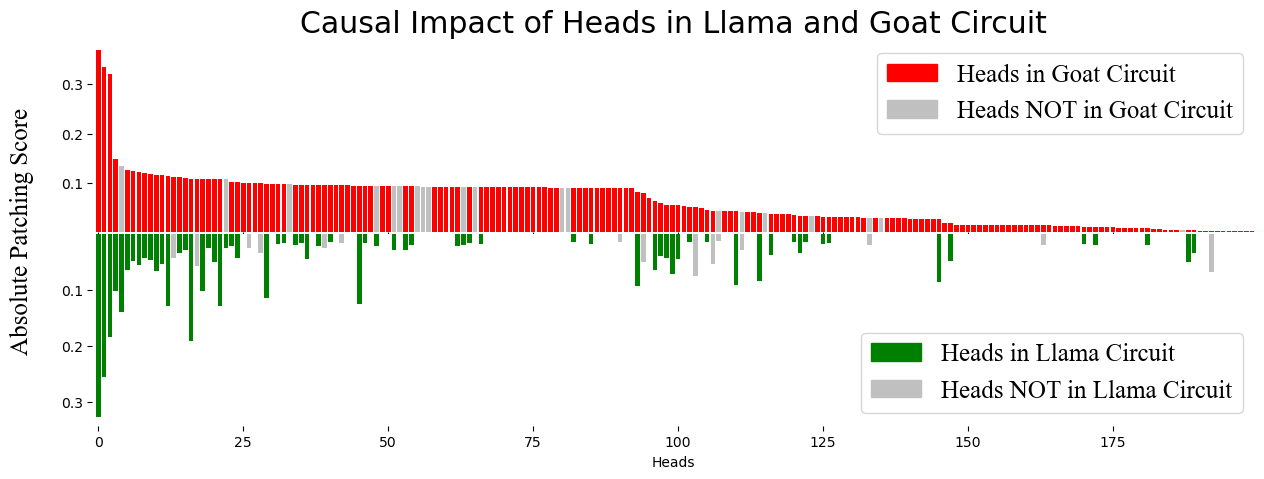

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

# Use times new roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

ax1.bar(
    [i for i in range(len(goat_circuit_tuple))],
    [score for _, score, _ in goat_circuit_tuple],
    color="red",
)
for i in range(len(goat_circuit_tuple)):
    if (
        goat_circuit_tuple[i][0] not in goat_value_fetcher
        and goat_circuit_tuple[i][0] not in goat_pos_transmitter
        and goat_circuit_tuple[i][0] not in goat_pos_detector
        and goat_circuit_tuple[i][0] not in goat_struct_reader
    ):
        ax1.bar(
            i,
            goat_circuit_tuple[i][1],
            color="silver",
        )

red_patch = mpatches.Patch(color="red", label="Heads in Goat Circuit")
silver_patch = mpatches.Patch(color="silver", label="Heads NOT in Goat Circuit")
ax1.legend(handles=[red_patch, silver_patch], loc="upper right")

ax2.bar(
    [i for i in range(len(ordered_llama_circuit_tuple))],
    [score for _, score, _ in ordered_llama_circuit_tuple],
    color="green",
)
for i in range(len(ordered_llama_circuit_tuple)):
    if (
        ordered_llama_circuit_tuple[i][0] not in llama_value_fetcher
        and ordered_llama_circuit_tuple[i][0] not in llama_pos_transmitter
        and ordered_llama_circuit_tuple[i][0] not in llama_pos_detector
        and ordered_llama_circuit_tuple[i][0] not in llama_struct_reader
    ):
        ax2.bar(
            i,
            ordered_llama_circuit_tuple[i][1],
            color="silver",
        )

green_patch = mpatches.Patch(color="green", label="Heads in Llama Circuit")
silver_patch = mpatches.Patch(color="silver", label="Heads NOT in Llama Circuit")
ax2.legend(handles=[green_patch, silver_patch], loc="lower right")

# Remove the blank space before and after the bar chart
plt.xlim(-1, 200 - 0.5)

# Reduce the gap between the two subplots
plt.subplots_adjust(hspace=0.01)
# Flip the y-axis of the second subplot
ax2.invert_yaxis()
# Remove 0.0 from the y-axis of the second subplot
ax1.set_yticks([0.1, 0.2, 0.3])
ax2.set_yticks([0.1, 0.2, 0.3])

# Set a single y-axis label for both subplots
fig.text(0.07, 0.5, "Absolute Patching Score", va="center", rotation="vertical")

ax2.set_xlabel("Heads")
ax1.set_title("Causal Impact of Heads in Llama and Goat Circuit")

# Remove plox plot frame
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Save the plot
plt.savefig("./results/figures/causal_impact.pdf", bbox_inches="tight", dpi=300)

## Analyzing Negative Heads

In [2]:
with open("./results/faithfulness_heads.json", "r") as f:
    llama_accs = json.load(f)

with open("./results/faithfulness_goat_heads.json", "r") as f:
    goat_accs = json.load(f)

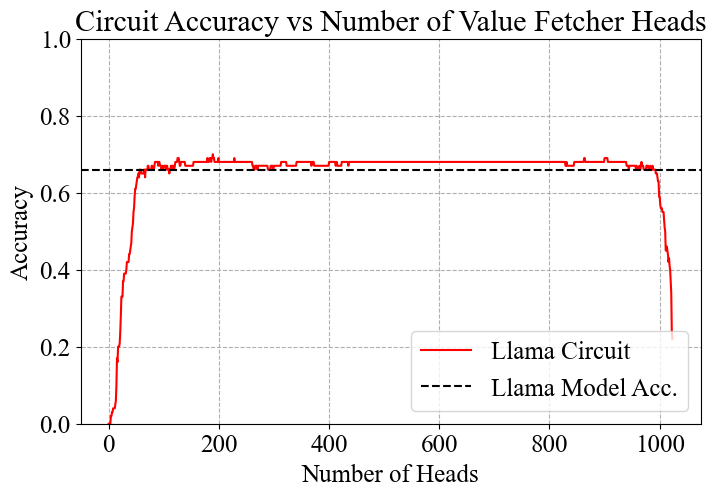

In [58]:
# Plot values of llama_accs['value_fetcher'] and goat_accs['value_fetcher']
fig, ax = plt.subplots(figsize=(8, 5))

# Use times new roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

ax.plot(
    [i for i in range(len(llama_accs["value_fetcher"]))],
    llama_accs["value_fetcher"],
    color="red",
    label="Llama Circuit",
)

# Add a horizontal line at y=0.66
ax.axhline(y=0.66, color="black", linestyle="--", label="Llama Model Acc.")

# Set y-axis limits
ax.set_ylim(0, 1)

ax.set_xlabel("Number of Heads")
ax.set_ylabel("Accuracy")
ax.set_title("Circuit Accuracy vs Number of Value Fetcher Heads")

ax.grid(True, linestyle="--")
ax.legend(loc="lower right")

plt.show()

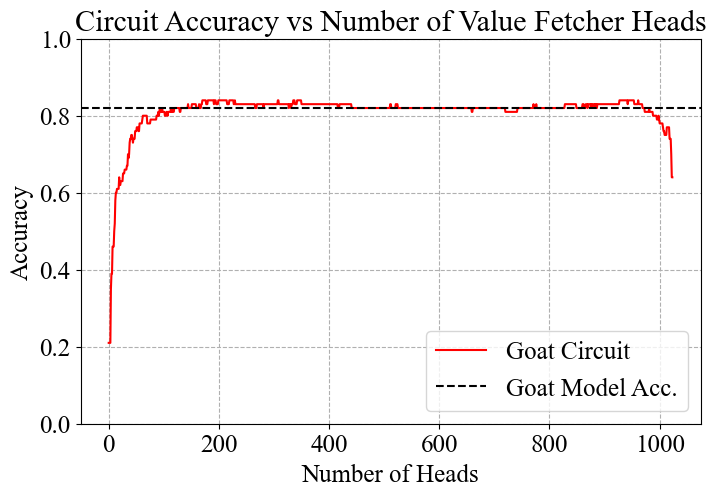

In [59]:
# Plot values of llama_accs['value_fetcher'] and goat_accs['value_fetcher']
fig, ax = plt.subplots(figsize=(8, 5))

# Use times new roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

ax.plot(
    [i for i in range(len(goat_accs["value_fetcher"]))],
    goat_accs["value_fetcher"],
    color="red",
    label="Goat Circuit",
)

# Add a horizontal line at y=0.66
ax.axhline(y=0.82, color="black", linestyle="--", label="Goat Model Acc.")

# Set y-axis limits
ax.set_ylim(0, 1)

ax.set_xlabel("Number of Heads")
ax.set_ylabel("Accuracy")
ax.set_title("Circuit Accuracy vs Number of Value Fetcher Heads")

ax.grid(True, linestyle="--")
ax.legend(loc="lower right")

plt.show()

In [13]:
def count_positive(scores):
    count = 0
    for score in scores:
        if score > 0:
            count += 1

    return count

In [14]:
circuit_name = "llama_circuit"

for head_group in ["value_fetcher", "pos_transmitter", "pos_detector", "struct_reader"]:
    patching_score = torch.load(f"./results/path_patching/{circuit_name}/{head_group}.pt")

    heads, patching_score = compute_topk_components(
        patching_score,
        k=1024,
        largest=False,
        return_values=True,
    )

    negative_head_count = count_positive(patching_score)

    print(f"Circuit: {circuit_name} | Head Group: {head_group} | Negative Heads: {negative_head_count}")

Circuit: llama_circuit | Head Group: value_fetcher | Negative Heads: 433
Circuit: llama_circuit | Head Group: pos_transmitter | Negative Heads: 510
Circuit: llama_circuit | Head Group: pos_detector | Negative Heads: 295
Circuit: llama_circuit | Head Group: struct_reader | Negative Heads: 217


In [15]:
circuit_name = "goat_circuit"

for head_group in ["value_fetcher", "pos_transmitter", "pos_detector", "struct_reader"]:
    patching_score = torch.load(
        f"./results/path_patching/{circuit_name}/{head_group}.pt"
    )

    heads, patching_score = compute_topk_components(
        patching_score,
        k=1024,
        largest=False,
        return_values=True,
    )

    negative_head_count = count_positive(patching_score)

    print(
        f"Circuit: {circuit_name} | Head Group: {head_group} | Negative Heads: {negative_head_count}"
    )

Circuit: goat_circuit | Head Group: value_fetcher | Negative Heads: 0
Circuit: goat_circuit | Head Group: pos_transmitter | Negative Heads: 980
Circuit: goat_circuit | Head Group: pos_detector | Negative Heads: 8
Circuit: goat_circuit | Head Group: struct_reader | Negative Heads: 1020


In [9]:
patching_score

[-0.10850125551223755,
 -0.059562984853982925,
 -0.05619224160909653,
 -0.011028805747628212,
 0.0016040584305301309,
 0.001972259022295475,
 0.0019843820482492447,
 0.0022008123341947794,
 0.0025954595766961575,
 0.0035187245812267065,
 0.0044072153978049755,
 0.005689613521099091,
 0.005977928172796965,
 0.008125347085297108,
 0.009114809334278107,
 0.00953338947147131,
 0.010054963640868664,
 0.010320820845663548,
 0.010813742876052856,
 0.011425736360251904,
 0.01184032578021288,
 0.012022966518998146,
 0.01209599245339632,
 0.013392739929258823,
 0.0135797169059515,
 0.013902492821216583,
 0.014091034419834614,
 0.014104041270911694,
 0.01424059271812439,
 0.014240632764995098,
 0.014412387274205685,
 0.014480671845376492,
 0.014640546403825283,
 0.014650591649115086,
 0.014736738987267017,
 0.014852199703454971,
 0.014879021793603897,
 0.015043772757053375,
 0.01504575926810503,
 0.01509955432265997,
 0.015159664675593376,
 0.01529684104025364,
 0.015322630293667316,
 0.015357302